#### For Colab

In [1]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'

#### Install Libraries

In [4]:
!pip install transformers==4.1.1
!pip install -U sentencepiece!=0.1.92
!pip install -U datasets
!pip install rouge_score
!pip install -U gensim

     |████████████████████████████████| 1.5MB 9.3MB/s 
     |████████████████████████████████| 890kB 27.9MB/s 
     |████████████████████████████████| 2.9MB 21.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=bb9bb3b6e0d25c1bd802d8f7cab31e6c30a6450382fe5367958f641bf01a18b2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 6.8MB/s 
     |████████████████████████████████| 163kB 9.1MB/s 
     |████████████████████████████████| 245kB 14.0MB/s 
     |████████████████████████████████| 17.7MB 248kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 24.2MB 1.5MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


### **Config**

In [5]:
import os
import sys

sys.path.insert(0, drive_dir)
import config

In [6]:
# General configurations

MODEL = 'bart'

RE_SPLITTER = '\.(?!\d)|\n'     # do we split sentences of paragraphs?
                                # use '\.|\n' or '\n', respectively

TOKEN_MAX_LEN = 99              # max length of a word
PARA_MIN_LENGTH = 2             # minimum length for a sentence or
                                # a paragraph, in tokens
                                
# Output path
OUTPUT_PATH = drive_dir+'datasets/karger_books_topic_modeling/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [7]:
# Topic modeling specific configurations

REDUCTION_MAX_LEN = 1024        # maximum length of the LDA/LSI/TextRank reduction

STOPWORDS_EXTENSION =\
    ['may', 'might',
     'also', 'with',
     'without', 'use',
     'uses', 'used', 'using']

STEMMER = 'snowball'            # name of the stemmer, might use 'porter'

N_GRAM = 2                      # the length of n-gram we want to create
N_GRAM_MIN_COUNT = 2            # there should be at least N_GRAM_MIN_COUNT
                                # repetitions in the text
N_GRAM_THRESHOLD = 20           # see gensim.Phrases documentation

DIC_NO_BELOW = 3                # keep tokens present in DIC_NO_BELOW+ sentences/paragraphs
DIC_NO_ABOVE = 1                # fraction of total corpus size (default: 1)

TOP_N = 30                      # number of words to keep for each topic

### **Init**

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
import gensim
from tqdm import tqdm

if 'pegasus' in MODEL:
    from transformers import PegasusTokenizer
    tokenizer =\
        PegasusTokenizer.from_pretrained('google/pegasus-large')
elif 'bart' in MODEL:
    from transformers import BartTokenizer
    tokenizer =\
        BartTokenizer.from_pretrained('facebook/bart-large-cnn')

### **Karger Books Base Dataset**

In [ ]:
base_dataset = drive_dir+'datasets/karger_books_base/df.csv'
df = pd.read_csv(base_dataset)
df = df.set_index(['book', 'chapter', 'section', 'subsection'])
df.bullets = df.bullets.map(eval, na_action='ignore')

## **Topic modeling**

### **Preprocessing**

#### Preprocessing

* Split based on RE_SPLITTER
* Explode the dataset
* Remove unwanted chars at beginning or end of sentence
* Remove multiple spaces
* Remove long words (> TOKEN_MAX_LEN chars)
* Remove short sentences / paragraphs (< PARA_MIN_LENGTH tokens)

In [ ]:
# Split in sentences / paragraphs based on RE_SPLITTER
df.text =\
    df.text.map(lambda x: [p.strip() for p in re.split(RE_SPLITTER, x) if p!=''],
                na_action='ignore')
    
# explode to get one row for each paragraph /sentence
df = df.explode('text')
df = df.rename(columns={'text': 'para'})
df = df.dropna()

# Remove unwanted chars at beginning or end of sentence
df.para = df.para.map(lambda p: p.lstrip('.,;:-)] \n'))
df.para = df.para.map(lambda p: p.rstrip('.,;:-([ \n'))

# Remove multiple spaces
df.para = df.para.map(lambda p:
    re.sub('\s+', ' ', p).strip())

# Remove long words (> TOKEN_MAX_LEN chars)
def para2words(para):
    return gensim.utils.simple_preprocess(
        para, deacc=True, max_len=TOKEN_MAX_LEN)
df['para_proc'] = df.para.map(para2words)

# Remove short sentences / paragraphs (< PARA_MIN_LENGTH tokens)
df.loc[df.para_proc.map(len) <\
    PARA_MIN_LENGTH, 'para_proc'] = np.nan

df = df.dropna()

### **Topic modeling**

#### Further Preprocessing

* Remove stop words
* Stem
* Create n-grams (N_GRAM)

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Remove stop words
stop_words.extend(STOPWORDS_EXTENSION)
df.para_proc = df.para_proc.map(lambda x:
    [w for w in x if w not in stop_words])

In [ ]:
# Stem
if 'port' in STEMMER:
    from nltk.stem.porter import PorterStemmer
    st = PorterStemmer()
elif 'snow' in STEMMER:
    from nltk.stem.snowball import SnowballStemmer
    st = SnowballStemmer('english')

df.para_proc = df.para_proc.map(lambda p:
    [st.stem(w) for w in p], na_action='ignore')

In [ ]:
# Create n-grams (N_GRAM)
data_words = df.para_proc.dropna().values.tolist()

if N_GRAM == 2:
    bigram = gensim.models.Phrases(
        data_words,
        min_count=N_GRAM_MIN_COUNT,
        threshold=N_GRAM_THRESHOLD)

    df.para_proc = df.para_proc.map(lambda p:
        [b for b in bigram[p]], na_action='ignore')
    
elif N_GRAM == 3:
    trigram = gensim.models.Phrases(
        bigram[data_words],
        min_count=N_GRAM_MIN_COUNT,
        threshold=N_GRAM_THRESHOLD)
    
    df.para_proc = df.para_proc.map(lambda p:
        [b for b in trigram[bigram[p]]], na_action='ignore')

#### Dictionary (DIC_NO_BELOW, DIC_NO_ABOVE)

In [ ]:
# Create dictionary for topic model (DIC_NO_BELOW, DIC_NO_ABOVE)
book_ch_comb = set(zip(df.index.get_level_values(0),
    df.index.get_level_values(1)))

id2word = {}
for book, ch in book_ch_comb:
    if book not in id2word:
        id2word[book] = {}

    id2word[book][ch] = gensim.corpora.Dictionary(
        df.loc[book, ch].para_proc.dropna().values.tolist() )

    id2word[book][ch].filter_extremes(
        no_below = DIC_NO_BELOW, no_above = DIC_NO_ABOVE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  # This is added back by InteractiveShellApp.init_path()


#### LDA

https://radimrehurek.com/gensim_3.8.3/models/ldamodel.html

https://www.di.ens.fr/~fbach/mdhnips2010.pdf

Keep N_TOP words.

In [ ]:
%%capture
def get_lda_model(df, book, ch):
    corpus = df.loc[book, ch].para_proc.map(id2word[book][ch].doc2bow,
        na_action='ignore').dropna().values.tolist()

    return gensim.models.ldamodel.LdaModel(
        corpus = corpus,
        num_topics = 1,
        id2word = id2word[book][ch],
        alpha = 'auto',
        random_state = config.SEED)

lda_word2prob = {}
for book, ch in book_ch_comb:       
    if book not in lda_word2prob:
        lda_word2prob[book] = {}

    lda_word2prob[book][ch] = dict(\
        get_lda_model(df, book, ch).show_topic(0, TOP_N))

#### TF-IDF | LSI (SVD) model

https://radimrehurek.com/gensim_3.8.3/models/tfidfmodel.html

https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing

Keep N_TOP words.

In [ ]:
%%capture
def get_lsi_model(df, book, ch):
    corpus = df.loc[book, ch].para_proc.map(id2word[book][ch].doc2bow,
        na_action='ignore').dropna().values.tolist()

    tfidf_model = gensim.models.TfidfModel(
        corpus = corpus,
        id2word = id2word[book][ch])
    tfidf_corpus = tfidf_model[corpus]

    return gensim.models.LsiModel(
        corpus = tfidf_corpus,
        num_topics = 1,
        id2word = id2word[book][ch])    

lsi_word2prob = {}
for book, ch in book_ch_comb:
    if book not in lsi_word2prob:
        lsi_word2prob[book] = {}

    lsi_word2prob[book][ch] = dict(\
        get_lsi_model(df, book, ch).show_topic(0, TOP_N))

### **Paragraph importance**

\begin{equation}
\text{importance}(p) = \frac{\sum_{w \in p} \text{probability}(w)}{\sqrt{\text{length}(p)}}\quad\quad\text{what about}\quad\frac{\sum_{w \in p} \text{probability}(w)}{log(\text{length}(p))}\quad?
\end{equation}

Where $p$ is a paragraph or a sentence, $w$ is a word (token) and $\text{probability}$ is the probability assigned by LDA or LSI model to $w$ (0 if it is not present in the TOP_N words).

In [ ]:
def word_importance(model_word2prob, word):
    return model_word2prob.get(word, 0)

def para_importance(model_word2prob, para):
    l_importance = [word_importance(model_word2prob, w) for w in para]
    return  np.sum(l_importance) / np.sqrt(len(l_importance))

df['lda_imp'] = np.nan
df['lda_imp_norm'] = np.nan
df['lsi_imp'] = np.nan
df['lsi_imp_norm'] = np.nan
for book, ch in book_ch_comb:
    idx_slice = pd.IndexSlice[book, ch, :, :]
    # getting LDA and LSI importance
    df.loc[idx_slice, 'lda_imp'] = df.loc[idx_slice, 'para_proc'].map(lambda p:
        para_importance(lda_word2prob[book][ch], p), na_action='ignore')
    df.loc[idx_slice, 'lsi_imp'] = df.loc[idx_slice, 'para_proc'].map(lambda p:
        -para_importance(lsi_word2prob[book][ch], p), na_action='ignore')

    # normalizing
    s = df.loc[idx_slice, 'lda_imp']
    df.loc[idx_slice, 'lda_imp_norm'] = s.sub(s.min()).div((s.max() - s.min()))
    s = df.loc[idx_slice, 'lsi_imp']
    df.loc[idx_slice, 'lsi_imp_norm'] = s.sub(s.min()).div((s.max() - s.min()))

df.para = df.para.map(lambda p: p+' . ')
df['n_tok'] = df.para.map(lambda p: len(tokenizer.encode(p)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


#### LDA vs LSI

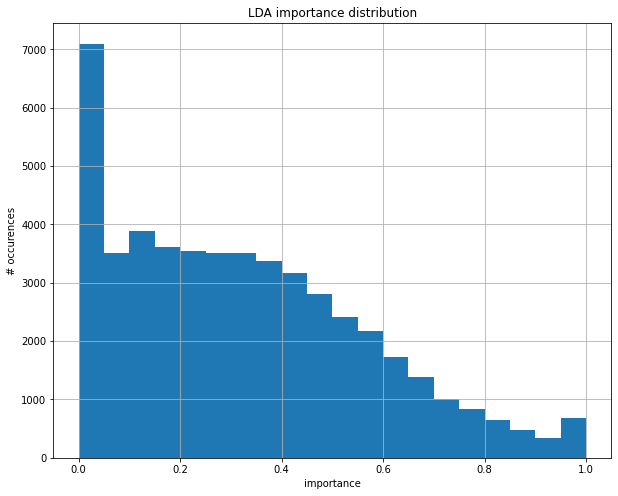

In [ ]:
plt.figure(figsize=(10, 8))
df.lda_imp_norm.hist(
    bins=20,
    histtype='bar')
plt.title('LDA importance distribution')
plt.xlabel('importance')
plt.ylabel('# occurences')

plt.savefig(OUTPUT_PATH+'lda_hist.png')
plt.show()

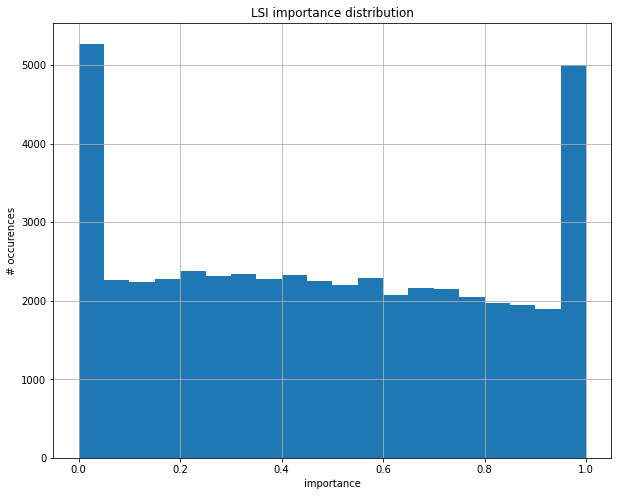

In [ ]:
plt.figure(figsize=(10, 8))
df.lsi_imp_norm.hist(
    bins=20,
    histtype='bar')
plt.title('LSI importance distribution')
plt.xlabel('importance')
plt.ylabel('# occurences')

plt.savefig(OUTPUT_PATH+'lsi_hist.png')
plt.show()

### **Reducing**

#### 0-1 Knapsack

In [ ]:
def knap_sack(max_l, df, name_value = 'lda_imp_norm'):
    """Return max possible good items fit within capacity.
    """

    df_rst = df.dropna().reset_index()
    m = [[0 for j in range(max_l + 1)] for i in range(len(df_rst))]
    for index, row in df_rst.iterrows():
        for j in range(1, max_l + 1):
            if j < row.n_tok:
                m[index][j] = m[index - 1][j]
            else:
                m[index][j] = max(row[name_value] +\
                                  m[index - 1][j - row.n_tok],
                    m[index - 1][j])

    ans = []
    i = len(df_rst) - 1
    j = max_l
    while i > 0 and j > 0:
        if m[i][j] != m[i - 1][j]:
            ans.append((i, df_rst.iloc[i].para))
            j -= df_rst.iloc[i].n_tok
        i -= 1

    ans = sorted(ans, key = lambda x: x[0])
    return [x[1] for x in ans]

#### LDA, LSI and TextRank reduction

* LDA, LSI: keep REDUCTION_MAX_LEN tokens and maximize importance
* TextRank: summarize from scratch (no topic modeling) https://arxiv.org/abs/1602.03606

In [ ]:
reductions = ['lda', 'lsi']

In [ ]:
df = df.sort_index()
print(df.index.is_lexsorted())

True


In [ ]:
from gensim.summarization.summarizer import summarize

df['lda_reduction'] = ''
df['lsi_reduction'] = ''
df['textrank_reduction'] = ''
for book, ch in tqdm(set(zip(df.index.get_level_values(0),
                        df.index.get_level_values(1)))):
    for redu in reductions:
        # LDA, LSI
        redu_text = knap_sack(REDUCTION_MAX_LEN,
            df.loc[book, ch], name_value = redu+'_imp_norm')
        df.loc[(book, ch), redu+'_reduction'] = ''.join(redu_text)

    # TextRank
    textrank_redu = summarize(
        df.loc[book, ch].para.str.cat(),
        word_count=int(0.5*REDUCTION_MAX_LEN),
        split=True)
    df.loc[(book, ch), 'textrank_reduction'] = ' '.join(textrank_redu)

reductions.append('textrank')

100%|██████████| 453/453 [28:31<00:00,  3.78s/it]


In [ ]:
df = df.groupby(level=[0, 1], sort=False).agg(
    {'para': lambda t: ''.join([p for p in t]),
     'bullets': lambda b: list(b)[0],
     'lda_reduction': lambda t: list(t)[0],
     'lsi_reduction': lambda t: list(t)[0],
     'textrank_reduction': lambda t: list(t)[0]})
df = df.rename(columns={'para': 'text'})

#### Number of remaining tokens

In [ ]:
for redu in reductions:
    print(redu)
    print(df[redu+'_reduction'].map(tokenizer.encode).map(len).describe())
    print()

lda
count    453.000000
mean     883.463576
std       38.790641
min      579.000000
25%      874.000000
50%      890.000000
75%      903.000000
max      941.000000
Name: lda_reduction, dtype: float64

lsi
count    453.000000
mean     871.805740
std       45.373156
min      579.000000
25%      861.000000
50%      883.000000
75%      899.000000
max      941.000000
Name: lsi_reduction, dtype: float64

textrank
count    453.00000
mean     684.89404
std       60.12875
min      555.00000
25%      640.00000
50%      678.00000
75%      720.00000
max      920.00000
Name: textrank_reduction, dtype: float64



### **Save New Dataset**

In [ ]:
df.bullets = df.bullets.map(lambda b: ' '.join(b))
df.to_csv(OUTPUT_PATH+'df.csv')

### **Create train, test, validation**

Generate files:
* train.source
* train.target
* val.source
* val.target
* test.source
* test.target

Since we do not have a lot of samples, validation and test will be equal for us.

In [9]:
df = pd.read_csv(OUTPUT_PATH+'df.csv')
df = df.set_index(['book', 'chapter'], drop=True)

reductions = ['lda', 'lsi', 'textrank']

In [10]:
for redu in reductions:
    op = OUTPUT_PATH + redu +'/'
    if not os.path.exists(op):
        os.makedirs(op)
    train, val, test =\
        np.split(df[[redu+'_reduction', 'bullets']].sample(frac=1, random_state=config.SEED), 
        [int(.8*len(df)), int(.9*len(df))])

    train.to_csv(op+'train.csv')
    val.to_csv(op+'val.csv')
    test.to_csv(op+'test.csv')

    with open(op+'train.source', 'w') as tr_s,\
        open(op+'train.target', 'w') as tr_t,\
        open(op+'train.index', 'w') as tr_i:
        for idx, row in train[[redu+'_reduction', 'bullets']].iterrows():
            tr_i.write(str(idx) + '\n')
            tr_s.write(row[redu+'_reduction'] + '\n')
            tr_t.write(row.bullets + '\n')
    with open(op+'val.source', 'w') as va_s,\
        open(op+'val.target', 'w') as va_t,\
        open(op+'val.index', 'w') as va_i:
        for idx, row in val[[redu+'_reduction', 'bullets']].iterrows():
            va_i.write(str(idx) + '\n')
            va_s.write(row[redu+'_reduction'] + '\n')
            va_t.write(row.bullets + '\n')
    with open(op+'test.source', 'w') as te_s,\
        open(op+'test.target', 'w') as te_t,\
        open(op+'test.index', 'w') as te_i:
        for idx, row in test[[redu+'_reduction', 'bullets']].iterrows():
            te_i.write(str(idx) + '\n')
            te_s.write(row[redu+'_reduction'] + '\n')
            te_t.write(row.bullets + '\n')